# Movies Recommender System Using Deep Learning

In [256]:
#importing the required libraries
import numpy as np
import pandas as pd
import pickle
import matrix_factorization_utilities
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [257]:
# Reading the ratings data
ratings = pd.read_csv('Dataset/ratings.csv')

In [258]:
len(ratings)

1048575

In [259]:
#Just taking the required columns
ratings = ratings[['userId', 'movieId','rating']]

In [260]:
# Checking if the user has rated the same movie twice, in that case we just take max of them
ratings_df = ratings.groupby(['userId','movieId']).aggregate(np.max)

In [261]:
# In this case there are no such cases where the user has rated the same movie twice.
len(ratings_df)

1048575

In [262]:
# Inspecting the data
ratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [263]:
ratings_df.head()

rating
userId movieId        
1      2           3.5
       29          3.5
       32          3.5
       47          3.5
       50          3.5

In [264]:
# Counting no of unique users
len(ratings['userId'].unique())

7120

In [265]:
#Getting the percentage count of each rating value 
count_ratings = ratings.groupby('rating').count()
count_ratings['perc_total']=round(count_ratings['userId']*100/count_ratings['userId'].sum(),1)

In [266]:
count_ratings

,userId,movieId,perc_total
rating,,,
0.5,13232,13232,1.3
1.0,35144,35144,3.4
1.5,14029,14029,1.3
2.0,74706,74706,7.1
2.5,44791,44791,4.3
3.0,226202,226202,21.6
3.5,112926,112926,10.8
4.0,295135,295135,28.1
4.5,79848,79848,7.6


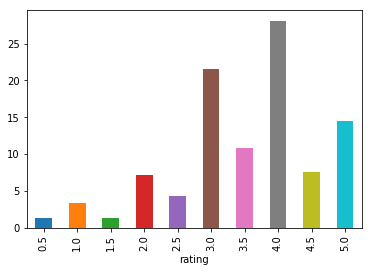

In [267]:
#Visualising the percentage total for each rating
count_ratings['perc_total'].plot.bar()

In [268]:
#reading the movies dataset
movie_list = pd.read_csv('Dataset/movies.csv')

In [269]:
len(movie_list)

27278

In [270]:
# insepcting the movie list dataframe
movie_list.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [271]:
# reading the tags datast
tags = pd.read_csv('Dataset/tags.csv')

In [272]:
# inspecting the tags data frame
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


# Using Weighted Average

In [273]:
# inspecting various genres
genres = movie_list['genres']

In [274]:
genres.head()

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

In [275]:
genre_list = ""
for index,row in movie_list.iterrows():
        genre_list += row.genres + "|"
#split the string into a list of values
genre_list_split = genre_list.split('|')
#de-duplicate values
new_list = list(set(genre_list_split))
#remove the value that is blank
new_list.remove('')
#inspect list of genres
new_list

['Musical',
 'Mystery',
 '(no genres listed)',
 'War',
 'Thriller',
 'Horror',
 'Romance',
 'Drama',
 'IMAX',
 'Children',
 'Fantasy',
 'Documentary',
 'Film-Noir',
 'Adventure',
 'Sci-Fi',
 'Crime',
 'Animation',
 'Action',
 'Western',
 'Comedy']

In [276]:
#Enriching the movies dataset by adding the various genres columns.
movies_with_genres = movie_list.copy()

for genre in new_list :
    movies_with_genres[genre] = movies_with_genres.apply(lambda _:int(genre in _.genres), axis = 1)

In [277]:
movies_with_genres.head()

,movieId,title,genres,Musical,Mystery,(no genres listed),War,Thriller,Horror,Romance,...,Fantasy,Documentary,Film-Noir,Adventure,Sci-Fi,Crime,Animation,Action,Western,Comedy
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [278]:
#Calculating the sparsity
no_of_users = len(ratings['userId'].unique())
no_of_movies = len(ratings['movieId'].unique())

sparsity = round(1.0 - len(ratings)/(1.0*(no_of_movies*no_of_users)),3)
print(sparsity)

0.99


In [279]:
# Counting the number of unique movies in the dataset.
len(ratings['movieId'].unique())

14026

In [414]:
# Finding the average rating for movie and the number of ratings for each movie
avg_movie_rating = pd.DataFrame(ratings.groupby('movieId')['rating'].agg(['mean','count']))
avg_movie_rating['movieId']= avg_movie_rating.index

In [415]:
# inspecting the average movie rating data frame
avg_movie_rating.head()

,mean,count,movieId
movieId,,,
0,3.959323,2569,0
1,3.268398,1155,1
2,3.186861,685,2
3,3.000000,138,3
4,3.143836,657,4


In [282]:
len(avg_movie_rating)

14026

In [416]:
#calculate the percentile count. It gives the no of ratings at least 70% of the movies have
np.percentile(avg_movie_rating['count'],70)

30.0

In [284]:
#Get the average movie rating across all movies 
avg_rating_all=ratings['rating'].mean()
avg_rating_all
#set a minimum threshold for number of reviews that the movie has to have
min_reviews=30
min_reviews
movie_score = avg_movie_rating.loc[avg_movie_rating['count']>min_reviews]
movie_score.head()

,mean,count,movieId
movieId,,,
1,3.959323,2569,1
2,3.268398,1155,2
3,3.186861,685,3
4,3.000000,138,4
5,3.143836,657,5


In [285]:
len(movie_score)

4173

In [286]:
#create a function for weighted rating score based off count of reviews
def weighted_rating(x, m=min_reviews, C=avg_rating_all):
    v = x['count']
    R = x['mean']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [287]:
#Calculating the weighted score for each movie
movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)
movie_score.head()

C:\Users\gureddy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,mean,count,movieId,weighted_score
movieId,,,,
1,3.959323,2569,1,3.954359
2,3.268398,1155,2,3.275003
3,3.186861,685,3,3.201228
4,3.000000,138,4,3.094513
5,3.143836,657,5,3.160667


In [288]:
#join movie details to movie ratings
movie_score = pd.merge(movie_score,movies_with_genres,on='movieId')
#join movie links to movie ratings
#movie_score = pd.merge(movie_score,links,on='movieId')
movie_score.head()

C:\Users\gureddy\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'movieId' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


,mean,count,movieId,weighted_score,title,genres,Musical,Mystery,(no genres listed),War,...,Fantasy,Documentary,Film-Noir,Adventure,Sci-Fi,Crime,Animation,Action,Western,Comedy
0,3.959323,2569,1,3.954359,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1
1,3.268398,1155,2,3.275003,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,3.186861,685,3,3.201228,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3.000000,138,4,3.094513,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3.143836,657,5,3.160667,Father of the Bride Part II (1995),Comedy,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [289]:
#list top scored movies over the whole range of movies
pd.DataFrame(movie_score.sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','genres']][:10])

,title,count,mean,weighted_score,genres
242,"Shawshank Redemption, The (1994)",3216,4.469994,4.461299,Crime|Drama
565,"Godfather, The (1972)",2137,4.388161,4.376270,Crime|Drama
46,"Usual Suspects, The (1995)",2490,4.370482,4.360468,Crime|Mystery|Thriller
403,Schindler's List (1993),2598,4.295612,4.286864,Drama|War
791,"Godfather: Part II, The (1974)",1418,4.278561,4.263037,Crime|Drama
3230,Band of Brothers (2001),228,4.353070,4.257280,Action|Drama|War
593,Casablanca (1942),1282,4.268721,4.251813,Drama|Romance
2937,City of God (Cidade de Deus) (2002),646,4.258514,4.226151,Action|Adventure|Crime|Drama|Thriller
589,North by Northwest (1959),817,4.250306,4.224768,Action|Adventure|Mystery|Romance|Thriller
3814,"Dark Knight, The (2008)",1031,4.242968,4.222788,Action|Crime|Drama|IMAX


In [290]:
# Gives the best movies according to genre based on weighted score which is calculated using IMDB formula
def best_movies_by_genre(genre,top_n):
    return pd.DataFrame(movie_score.loc[(movie_score[genre]==1)].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score']][:top_n])

In [291]:
#run function to return top recommended movies by genre
best_movies_by_genre('Musical',10)  

,title,count,mean,weighted_score
824,Duck Soup (1933),280,4.217857,4.151220
580,Singin' in the Rain (1952),542,4.097786,4.067969
3909,Dr. Horrible's Sing-Along Blog (2008),185,4.148649,4.062224
1777,Stop Making Sense (1984),119,4.142857,4.019316
2647,Fiddler on the Roof (1971),165,4.048485,3.968606
600,"Wizard of Oz, The (1939)",1229,3.947518,3.937552
588,"Gay Divorcee, The (1934)",57,4.149123,3.935381
1438,Nashville (1975),128,4.015625,3.923279
624,Top Hat (1935),120,4.004167,3.909188
3297,"Day at the Races, A (1937)",51,4.117647,3.899730


In [292]:
#run function to return top recommended movies by genre
best_movies_by_genre('Action',10)  

,title,count,mean,weighted_score
3230,Band of Brothers (2001),228,4.353070,4.257280
2937,City of God (Cidade de Deus) (2002),646,4.258514,4.226151
589,North by Northwest (1959),817,4.250306,4.224768
3814,"Dark Knight, The (2008)",1031,4.242968,4.222788
1838,Fight Club (1999),2085,4.219185,4.209399
769,Raiders of the Lost Ark (Indiana Jones and the...,2289,4.206204,4.197446
1256,Seven Samurai (Shichinin no samurai) (1954),594,4.223906,4.190510
199,Star Wars: Episode IV - A New Hope (1977),2874,4.189457,4.182637
1629,"Matrix, The (1999)",2705,4.176340,4.169242
768,"Princess Bride, The (1987)",1725,4.177391,4.166312


In [293]:
#run function to return top recommended movies by genre
best_movies_by_genre('Children',10)  

,title,count,mean,weighted_score
518,Wallace & Gromit: A Close Shave (1995),622,4.176045,4.146286
741,Wallace & Gromit: The Wrong Trousers (1993),798,4.133459,4.111568
793,"Grand Day Out with Wallace and Gromit, A (1989)",379,4.100264,4.058382
3833,WALL·E (2008),654,4.074159,4.050260
2927,My Neighbor Totoro (Tonari no Totoro) (1988),262,4.104962,4.045816
1753,"Christmas Story, A (1983)",686,4.035714,4.014495
3991,How to Train Your Dragon (2010),234,4.064103,4.003326
3931,Up (2009),502,4.030876,4.002591
4004,Toy Story 3 (2010),306,4.042484,3.996661
2989,Laputa: Castle in the Sky (Tenkû no shiro Rapy...,183,4.046448,3.973606


In [294]:
#run function to return top recommended movies by genre
best_movies_by_genre('Drama',10)  

,title,count,mean,weighted_score
242,"Shawshank Redemption, The (1994)",3216,4.469994,4.461299
565,"Godfather, The (1972)",2137,4.388161,4.376270
403,Schindler's List (1993),2598,4.295612,4.286864
791,"Godfather: Part II, The (1974)",1418,4.278561,4.263037
3230,Band of Brothers (2001),228,4.353070,4.257280
593,Casablanca (1942),1282,4.268721,4.251813
2937,City of God (Cidade de Deus) (2002),646,4.258514,4.226151
3814,"Dark Knight, The (2008)",1031,4.242968,4.222788
765,One Flew Over the Cuckoo's Nest (1975),1538,4.235696,4.222180
1838,Fight Club (1999),2085,4.219185,4.209399


#  Deep Learning

In [358]:
#import libraries
import keras
from keras.layers import Embedding, Reshape, Merge
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [359]:
from keras.utils import plot_model

In [361]:
# Couting no of unique users and movies
len(ratings.userId.unique()), len(ratings.movieId.unique())

(7120, 14026)

In [368]:
# Assigning a unique value to each user and movie in range 0,no_of_users and 0,no_of_movies respectively.
ratings.userId = ratings.userId.astype('category').cat.codes.values
ratings.movieId = ratings.movieId.astype('category').cat.codes.values

In [369]:
# Splitting the data into train and test.
train, test = train_test_split(ratings, test_size=0.2)

In [371]:
train.head()

,userId,movieId,rating
529659,3575,6693,3.0
628702,4214,2943,4.0
921611,6150,9537,4.5
205369,1410,6947,1.5
457129,3116,5217,3.0


In [372]:
test.head()

,userId,movieId,rating
705247,4677,693,5.0
840181,5600,5162,4.0
370752,2513,407,3.0
680022,4518,9187,2.5
386216,2642,1140,3.0


In [373]:
n_users, n_movies = len(ratings.userId.unique()), len(ratings.movieId.unique())

In [374]:
# Returns a neural network model which performs matrix factorisation
def matrix_factorisation_model_with_n_latent_factors(n_latent_factors) :
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))
    prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
    
    model = keras.Model([user_input, movie_input], prod)
    model.compile('adam', 'mean_squared_error')
    
    return model

In [385]:
model = matrix_factorisation_model_with_n_latent_factors(5)

C:\Users\gureddy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
C:\Users\gureddy\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [386]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 5)         70135       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         35605       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [390]:
#Training the model
history = model.fit([train.userId, train.movieId], train.rating, epochs=50, verbose=0)

In [391]:
y_hat = np.round(model.predict([test.userId, test.movieId]),0)
y_true = test.rating

In [392]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.64568581169682659

In [393]:
#Getting summary of movie embeddings
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2,3,4
count,14027.000000,14027.000000,14027.000000,14027.000000,14027.000000
mean,-0.584796,0.554704,0.573179,0.543056,-0.572827
std,0.325645,0.370988,0.344475,0.362717,0.511071
min,-1.963836,-1.217293,-1.716879,-1.473400,-3.367397
25%,-0.780295,0.344472,0.371849,0.323731,-0.818733
50%,-0.612994,0.601410,0.603311,0.580123,-0.592860
75%,-0.393885,0.770797,0.771625,0.758554,-0.268880
max,1.737474,2.446507,2.321894,2.295453,2.053888


In [394]:
# Getting summary of user embeddings from the model
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2,3,4
count,7121.000000,7121.000000,7121.000000,7121.000000,7121.000000
mean,-1.441774,1.158949,0.995655,1.158363,-0.922638
std,0.445552,0.593889,0.586042,0.671087,0.661188
min,-2.832839,-2.562927,-2.131705,-2.797889,-3.622658
25%,-1.729032,0.822518,0.661902,0.759129,-1.350732
50%,-1.473317,1.157800,1.014819,1.188419,-0.917977
75%,-1.186000,1.514922,1.348338,1.562538,-0.503780
max,1.541291,3.823552,3.735326,4.918538,1.842927


In [395]:
from keras.constraints import non_neg

In [396]:
# Returns a neural network model which performs matrix factorisation with additional constraint on embeddings(that they can't be negative)
def matrix_factorisation_model_with_n_latent_factors_and_non_negative_embedding(n_latent_factors) :
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Non-Negative-Movie-Embedding',embeddings_constraint=non_neg())(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='Non-Negative-User-Embedding',embeddings_constraint=non_neg())(user_input))
    prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
    
    model = keras.Model([user_input, movie_input], prod)
    model.compile('adam', 'mean_squared_error')
    
    return model

In [397]:
model2 = matrix_factorisation_model_with_n_latent_factors_and_non_negative_embedding(5)

C:\Users\gureddy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
C:\Users\gureddy\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [412]:
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Non-Negative-Movie-Embedding (E (None, 1, 5)         70135       Item[0][0]                       
__________________________________________________________________________________________________
Non-Negative-User-Embedding (Em (None, 1, 5)         35605       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [398]:
history_nonneg = model2.fit([train.userId, train.movieId], train.rating, epochs=50, verbose=0)

In [399]:
movie_embedding_learnt = model2.get_layer(name='Non-Negative-Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2,3,4
count,14027.000000,14027.000000,14027.000000,14027.000000,14027.000000
mean,0.593803,0.577534,0.539951,0.556110,0.574022
std,0.324521,0.325505,0.290940,0.302161,0.321179
min,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
25%,0.386639,0.344631,0.341899,0.355270,0.354777
50%,0.605978,0.608381,0.571152,0.579772,0.605287
75%,0.778993,0.786552,0.728412,0.746384,0.777170
max,2.186076,1.769787,1.848414,1.963175,2.172031


In [401]:
y_hat = np.round(model2.predict([test.userId, test.movieId]),0)
y_true = test.rating

In [402]:
mean_absolute_error(y_true, y_hat)

0.64118446463057011

In [409]:
# Returns a neural network model which does recommendation
def neural_network_model(n_latent_factors_user, n_latent_factors_movie):
    
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
    movie_vec = keras.layers.Dropout(0.2)(movie_vec)


    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
    user_vec = keras.layers.Dropout(0.2)(user_vec)


    concat = keras.layers.merge([movie_vec, user_vec], mode='concat',name='Concat')
    concat_dropout = keras.layers.Dropout(0.2)(concat)
    dense = keras.layers.Dense(100,name='FullyConnected')(concat)
    dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
    dense_2 = keras.layers.Dense(50,name='FullyConnected-1')(concat)
    dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
    dense_3 = keras.layers.Dense(20,name='FullyConnected-2')(dense_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
    dense_4 = keras.layers.Dense(10,name='FullyConnected-3', activation='relu')(dense_3)


    result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
    adam = Adam(lr=0.005)
    model = keras.Model([user_input, movie_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')
    return model

In [410]:
model3 = neural_network_model(10,13)

C:\Users\gureddy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
C:\Users\gureddy\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [411]:
history_neural_network = model3.fit([train.userId, train.movieId], train.rating, epochs=50, verbose=0)

In [413]:
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 13)        182351      Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 10)        71210       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [417]:
y_hat = np.round(model3.predict([test.userId, test.movieId]),0)
y_true = test.rating

In [418]:
mean_absolute_error(y_true, y_hat)

0.6582647879264717